<a href="https://colab.research.google.com/github/mc-off/ML/blob/main/RPS-prediction/RPS-prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Manual preprocessing

I just decided to do manual keying and resize each images and check how the accuracy changed by comparison with keras preprocessing

In [ ]:
import cv2
import glob
import os
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)

Mounted at /content/gdrive/


In [ ]:
basedir = '/content/gdrive/My Drive/data/rockpaperscissors/rps-cv-images/'

### Check how does it look like: 

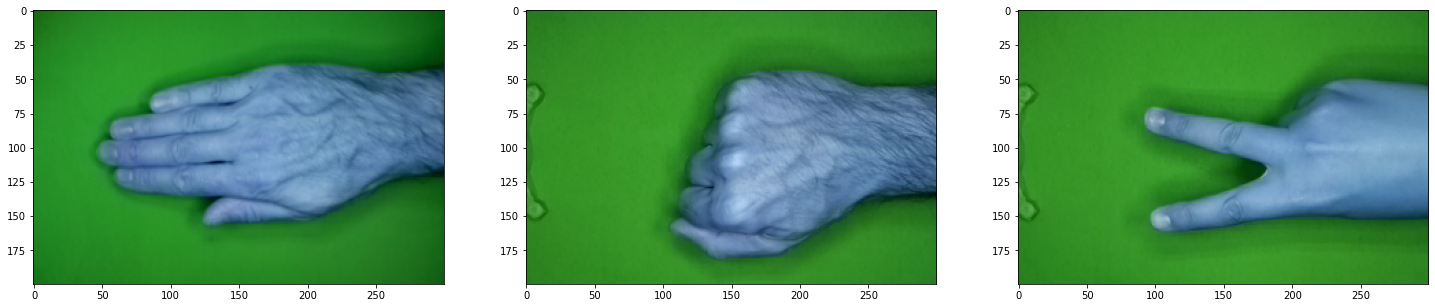

In [ ]:
paper = cv2.imread(basedir+'paper/1jHtb93pI8f6pfKo.png')
rock = cv2.imread(basedir+'rock/0bioBZYFCXqJIulm.png')
scissors = cv2.imread(basedir+'scissors/1L1n6plr7jlZGirw.png')

plt.subplots(1,3, figsize=(25,10))

plt.subplot(1,3,1)
plt.imshow(paper)

plt.subplot(1,3,2)
plt.imshow(rock)

plt.subplot(1,3,3)
plt.imshow(scissors)
plt.show()

### What we gonna do: 

- Replacing the green with a white background


- Resizing from **300W by 200H** to **300W by 300H** maintaining aspect ratio


- Rotating the image 90 degrees clockwise

Let's test on one image

In [ ]:
class_names = ['paper','rock','scissors']
class_names

['paper', 'rock', 'scissors']

In [ ]:
class_paths = glob.glob(basedir+f'{class_names[2]}/*.png')
ex_image_path = class_paths[0]
ex_image_path

'/content/gdrive/My Drive/data/rockpaperscissors/rps-cv-images/scissors/46fOqpoVsNjc9m9m.png'

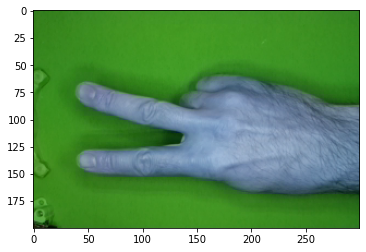

In [ ]:
ex_image = cv2.imread(ex_image_path)

plt.figure()
plt.imshow(ex_image)
plt.show()

To replace green screen we can use `cv2.floodFill()` that connecting pixels starting from the image corners

`cv2.Canny()` edge detection output will be used as a `mask` to stop the floodFill at the hand outline. 

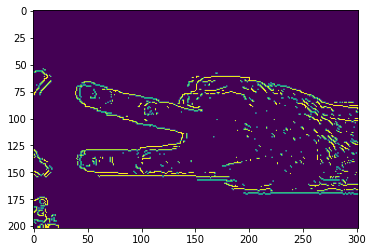

In [ ]:
image_edges = cv2.Canny(ex_image, 100,100)

image_mask = cv2.copyMakeBorder(image_edges,1,1,1,1,cv2.BORDER_REFLECT)

plt.figure()
plt.imshow(image_mask)
plt.show()

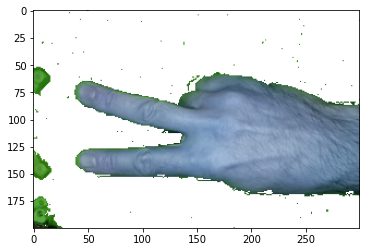

In [ ]:
ex_image_filed = ex_image.copy()

cv2.floodFill(image=ex_image_filed, mask=image_mask, seedPoint=(10,4), newVal=(255,255,255), 
              loDiff=(2,151,100), upDiff=(2,151,100), flags=8)
cv2.floodFill(ex_image_filed, image_mask, (11,197), (255,255,255), (2,151,100), (2,151,100), flags=8)
cv2.floodFill(ex_image_filed, image_mask, (299,3), (255,255,255), (2,151,65), (2,151,65), flags=8)
cv2.floodFill(ex_image_filed, image_mask, (299,198), (255,255,255), (2,151,65), (2,151,65), flags=8)


plt.figure()
plt.imshow(ex_image_filed)
plt.show()

Resizing

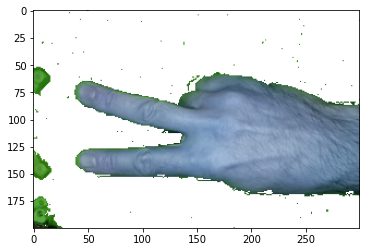

In [ ]:
final_size = 300

original_size = ex_image_filed.shape[:2] 
scale_percent = float(final_size)/max(original_size)

new_size = tuple([int(x*scale_percent) for x in original_size])

ex_image_resized = cv2.resize(ex_image_filed, (new_size[1], new_size[0]))

plt.figure()
plt.imshow(ex_image_resized)
plt.show()

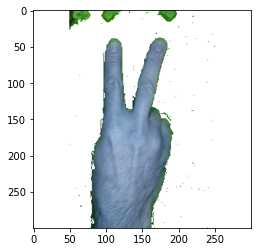

In [ ]:
delta_w = final_size - new_size[1]
delta_h = final_size - new_size[0]
        
top_border = delta_h//2
bottom_border = delta_h - top_border
left_border = delta_w//2
right_border = delta_w - left_border

all_white = [255, 255, 255]
        
with_border = cv2.copyMakeBorder(src=resized, top=top_border, bottom=bottom_border, left=left_border, 
                                 right=right_border, borderType=cv2.BORDER_CONSTANT, value=all_white)
        
final_image = cv2.rotate(with_border, cv2.ROTATE_90_CLOCKWISE)

plt.figure()
plt.imshow(final_image)
plt.show()

## Generation of new data

In [ ]:
for name in class_names: 

    os.chdir(basedir)
    class_paths = glob.glob(f'{name}/*.png')
    
    image_names = [] 
    
    for path in class_paths: 

        path_removed = path.replace(f'{name}/','')
        type_removed = path_removed.replace('.png','')

        print(f'{path} vs {type_removed}')

        image_names.append(type_removed)
    

    for index in np.arange(0,len(class_paths)):

        os.chdir(basedir)
      
        read_image = cv2.imread(class_paths[index], cv2.COLOR_BGR2RGB)
        
        original_size = read_image.shape[:2]
        
        detect_edge = cv2.Canny(read_image, 100, 100)
        edge_mask = cv2.copyMakeBorder(detect_edge,1,1,1,1,cv2.BORDER_REFLECT)

        filled = read_image.copy()
        
        cv2.floodFill(image=filled, mask=edge_mask, seedPoint=(10,3), newVal=(255,255,255), 
                      loDiff=(2,151,100), upDiff=(2,151,100), flags=8)
        cv2.floodFill(filled, edge_mask, (10,197), (255,255,255), (2,151,100), (2,151,100), flags=8)
        cv2.floodFill(filled, edge_mask, (299,3), (255,255,255), (2,151,65), (2,151,65), flags=8)
        cv2.floodFill(filled, edge_mask, (299,197), (255,255,255), (2,151,65), (2,151,65), flags=8)
        
        scale_percent = float(final_size)/max(original_size)
        new_size = tuple([int(x*scale_percent) for x in original_size])

        resized = cv2.resize(filled, (new_size[1], new_size[0]))
        
        delta_w = final_size - new_size[1]
        delta_h = final_size - new_size[0]
        
        top_border = delta_h//2
        bottom_border = delta_h - top_border
        left_border = delta_w//2
        right_border = delta_w - left_border

        all_white = [255, 255, 255]
        
        with_border = cv2.copyMakeBorder(src=resized, top=top_border, bottom=bottom_border, 
                                         left=left_border, right=right_border, 
                                         borderType=cv2.BORDER_CONSTANT, value=all_white)
        
        final_image = cv2.rotate(with_border, cv2.ROTATE_90_CLOCKWISE)

        os.chdir(f'training_set/{name}/')

        status = cv2.imwrite(f'{image_names[index]}.png', final_image)
        
        print(f'{image_names[index]} resized, rotated and saved to "{name}" folder. {status}')     

paper/1yeoLbmp4alVOtFv.png vs 1yeoLbmp4alVOtFv
paper/2tDgPZGqbrw95j39.png vs 2tDgPZGqbrw95j39
paper/04l5I8TqdzF9WDMJ.png vs 04l5I8TqdzF9WDMJ
paper/3sKeYzYsjbWQVhc4.png vs 3sKeYzYsjbWQVhc4
paper/54xah1BB0YTQS3Ib.png vs 54xah1BB0YTQS3Ib
paper/5Cy2fFOaWMFwa5iu.png vs 5Cy2fFOaWMFwa5iu
paper/3tNHP8R9YHru011u.png vs 3tNHP8R9YHru011u
paper/4fCqIVTEuFLsQMaZ.png vs 4fCqIVTEuFLsQMaZ
paper/0RA9rcrv8iVvuDDU.png vs 0RA9rcrv8iVvuDDU
paper/389udM70tLrMVL5H.png vs 389udM70tLrMVL5H
paper/0Og76sl5CJhbxWWx.png vs 0Og76sl5CJhbxWWx
paper/2DQbLQfHlfrcATqi.png vs 2DQbLQfHlfrcATqi
paper/5RvFm2PYoG18yIZO.png vs 5RvFm2PYoG18yIZO
paper/3tyVmhojjwETaf1u.png vs 3tyVmhojjwETaf1u
paper/2UKnsncgPodQLOFR.png vs 2UKnsncgPodQLOFR
paper/2SldJqjiZwIVPef9.png vs 2SldJqjiZwIVPef9
paper/2OCAZGNv2OEzgAwU.png vs 2OCAZGNv2OEzgAwU
paper/52nvTykEONIdmqQI.png vs 52nvTykEONIdmqQI
paper/5Iz9WPYz1C3PKWxj.png vs 5Iz9WPYz1C3PKWxj
paper/2F8Ng7620ANA7tEK.png vs 2F8Ng7620ANA7tEK
paper/0a3UtNzl5Ll3sq8K.png vs 0a3UtNzl5Ll3sq8K
paper/27XFtQj

#Tests

In [ ]:
import tensorflow as tf
import pandas as pd
import keras
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import *
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16, Xception
from keras.applications.resnet50 import ResNet50

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)

Mounted at /content/gdrive/


In [ ]:
basedir = '/content/gdrive/My Drive/data/rockpaperscissors/'
raw_data_dir = basedir +'rps-cv-images'
proc_data_dir = basedir +'training_set'

###Raw

In [ ]:
raw_img_gen = ImageDataGenerator(
    rescale=1./255,        
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True,
    width_shift_range=0.2, 
    height_shift_range=0.2,
    validation_split = 0.2,
    fill_mode='nearest'
) 

In [ ]:
train = raw_img_gen.flow_from_directory(
    raw_data_dir,
    target_size = (200,200),
    batch_size=16,
    class_mode = 'categorical',
    shuffle=True,
    color_mode = 'rgb',
    subset = 'training'
)

val = raw_img_gen.flow_from_directory(
    raw_data_dir,
    target_size=(200,200),
    batch_size=16,
    class_mode='categorical',
    shuffle=False,
    color_mode = 'rgb',
    subset = 'validation'
)

train.class_indices

Found 1759 images belonging to 3 classes.
Found 439 images belonging to 3 classes.


{'paper': 0, 'rock': 1, 'scissors': 2}

###PreProcessed

In [ ]:
pre_img_gen = ImageDataGenerator(
    rescale=1./255,        
    zoom_range=0.2,
    width_shift_range=0.2, 
    height_shift_range=0.2,
    validation_split = 0.2,
    fill_mode='nearest'
) 

In [ ]:
pre_train = pre_img_gen.flow_from_directory(
    proc_data_dir,
    target_size = (200,200),
    batch_size=16,
    class_mode = 'categorical',
    shuffle=True,
    color_mode = 'rgb',
    subset = 'training'
)

pre_val = raw_img_gen.flow_from_directory(
    proc_data_dir,
    target_size=(200,200),
    batch_size=16,
    class_mode='categorical',
    shuffle=False,
    color_mode = 'rgb',
    subset = 'validation'
)

pre_train.class_indices

Found 1759 images belonging to 3 classes.
Found 439 images belonging to 3 classes.


{'paper': 0, 'rock': 1, 'scissors': 2}

### Util

In [ ]:
def show_accuracy_and_loss_trands(backlog):
  fig, axs = plt.subplots(1, 2, figsize=(20, 5))

  axs[0].set_title('Loss')
  axs[0].plot(backlog.history['loss'], color='red', label='train')
  axs[0].plot(backlog.history['val_loss'], color='green', label='validation')

  axs[1].set_title('Accuracy')
  axs[1].plot(backlog.history['accuracy'], color='red', label='train')
  axs[1].plot(backlog.history['val_accuracy'], color='green', label='validation')

  plt.legend(loc="best")
  fig.show()

In [ ]:
def show_eval(model, val):
  _, acc = model.evaluate(x=val, steps=len(val))
  print('Accuracy: %.f' % (acc * 100.0))
  return acc

## Model

###Data

In [ ]:
num_classes=3
classes = 3 
pixels = 200
channels = 3 #if 3 'color_mode="rgb"', if 1 'color_mode="grayscale"'
batch_size = 20

# Training the model for a minimum of 12 and maximum of 30 epochs
min_epochs=12
epochs=15

img_rows,img_cols=200,200

In [ ]:
sgd_optimizer = keras.optimizers.SGD(lr=0.001)

In [ ]:
adam_optimezer = keras.optimizers.Adam(lr=0.001)

In [ ]:
adagrad_optimezer = keras.optimizers.Adagrad(lr=0.001)

###Model1

In [ ]:
model_1 = Sequential([Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', 
                           input_shape=(pixels,pixels,channels)),
                    MaxPooling2D(pool_size=(2,2)),
                    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
                    MaxPooling2D(pool_size=(2,2)),
                    Dropout(rate=0.25),
                    Conv2D(filters=64, kernel_size=(3,3), padding='same',activation='relu'),
                    MaxPooling2D(pool_size=(2,2)),
                    Conv2D(filters=128, kernel_size=(3,3), padding='same',activation='relu'),
                    MaxPooling2D(pool_size=(2,2)),
                    Dropout(rate=0.25),
                    Flatten(),
                    Dropout(rate=0.5),
                    Dense(units=512, activation='relu'),
                    Dense(units=num_classes, activation='softmax')])

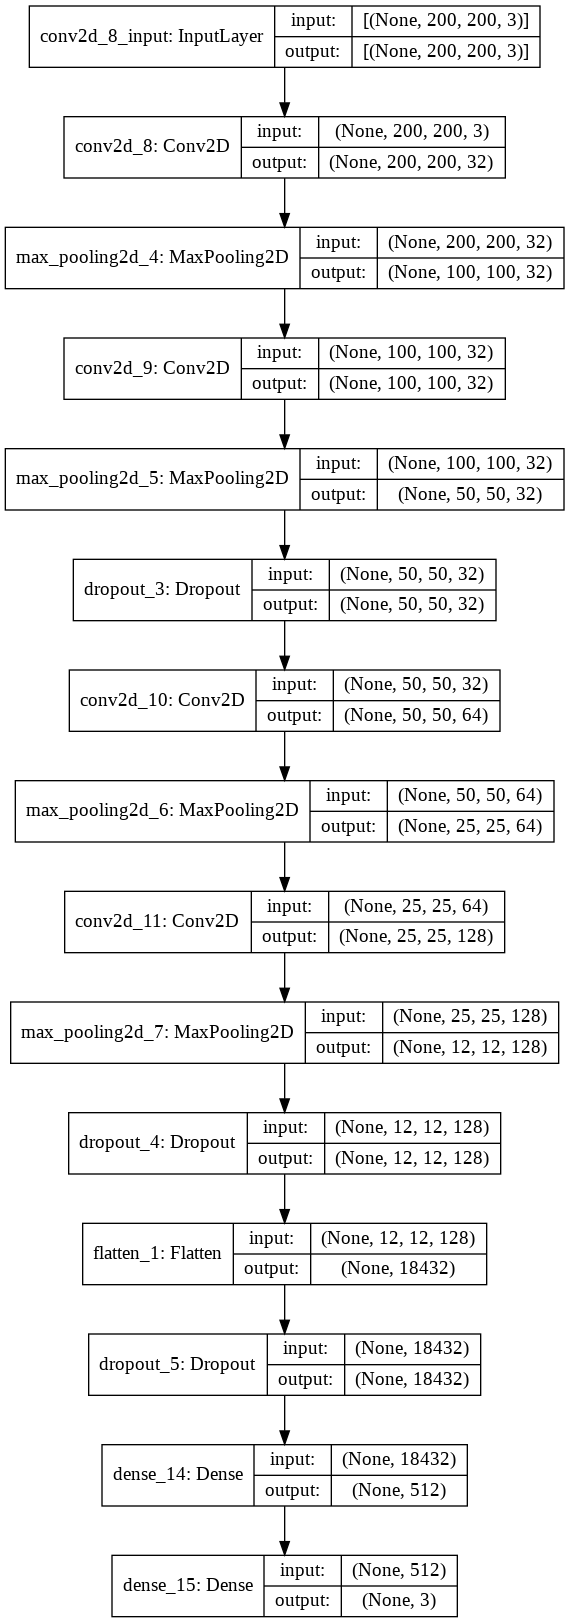

In [ ]:
plot_model(model_1, show_shapes=True, show_layer_names=True)

####Test optimizers

######SGD

In [ ]:
model_1.compile(sgd_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_1_sgd = model_1.fit(train, epochs=epochs, validation_data=val)

Epoch 1/15
110/110 [==============================] - 24s 217ms/step - loss: 1.1005 - accuracy: 0.3345 - val_loss: 1.1008 - val_accuracy: 0.3827
Epoch 2/15
110/110 [==============================] - 23s 214ms/step - loss: 1.0974 - accuracy: 0.3358 - val_loss: 1.0998 - val_accuracy: 0.3349
Epoch 3/15
110/110 [==============================] - 23s 214ms/step - loss: 1.1009 - accuracy: 0.3231 - val_loss: 1.1004 - val_accuracy: 0.3166
Epoch 4/15
110/110 [==============================] - 24s 215ms/step - loss: 1.0984 - accuracy: 0.3519 - val_loss: 1.0990 - val_accuracy: 0.3326
Epoch 5/15
110/110 [==============================] - 24s 215ms/step - loss: 1.0959 - accuracy: 0.3528 - val_loss: 1.0964 - val_accuracy: 0.3645
Epoch 6/15
110/110 [==============================] - 24s 215ms/step - loss: 1.0961 - accuracy: 0.3636 - val_loss: 1.0966 - val_accuracy: 0.3485
Epoch 7/15
110/110 [==============================] - 24s 217ms/step - loss: 1.0972 - accuracy: 0.3579 - val_loss: 1.0950 - val_ac

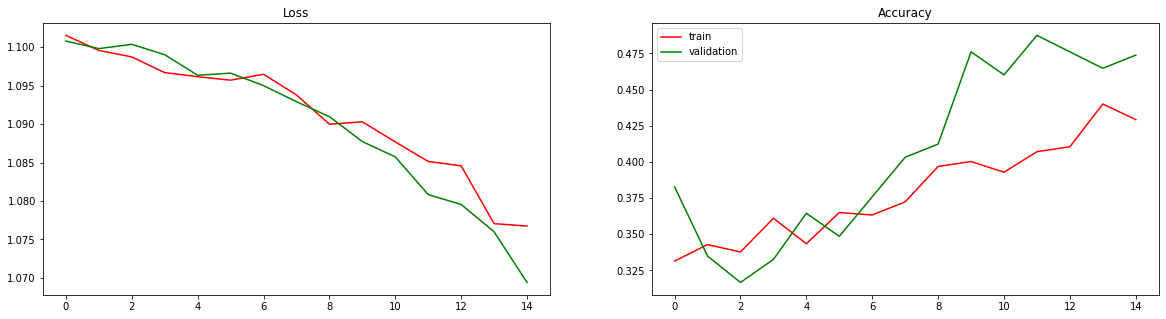

In [ ]:
show_accuracy_and_loss_trands(history_1_sgd)

In [ ]:
model_1_sgd_acc = show_eval(model_1, val)

28/28 [==============================] - 5s 163ms/step - loss: 1.0693 - accuracy: 0.5080
Accuracy: 51


######ADAM

In [ ]:
model_1.compile(adam_optimezer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_1_adam = model_1.fit(train, epochs=epochs, validation_data=val)

Epoch 1/15
110/110 [==============================] - 24s 217ms/step - loss: 1.2210 - accuracy: 0.3920 - val_loss: 1.0073 - val_accuracy: 0.4328
Epoch 2/15
110/110 [==============================] - 24s 215ms/step - loss: 0.9769 - accuracy: 0.5054 - val_loss: 0.5883 - val_accuracy: 0.7859
Epoch 3/15
110/110 [==============================] - 24s 216ms/step - loss: 0.6741 - accuracy: 0.7018 - val_loss: 0.3850 - val_accuracy: 0.8929
Epoch 4/15
110/110 [==============================] - 24s 214ms/step - loss: 0.4687 - accuracy: 0.8111 - val_loss: 0.4437 - val_accuracy: 0.8405
Epoch 5/15
110/110 [==============================] - 24s 215ms/step - loss: 0.3962 - accuracy: 0.8535 - val_loss: 0.3839 - val_accuracy: 0.8633
Epoch 6/15
110/110 [==============================] - 24s 215ms/step - loss: 0.3373 - accuracy: 0.8787 - val_loss: 0.4087 - val_accuracy: 0.8907
Epoch 7/15
110/110 [==============================] - 24s 218ms/step - loss: 0.2685 - accuracy: 0.9110 - val_loss: 0.3555 - val_ac

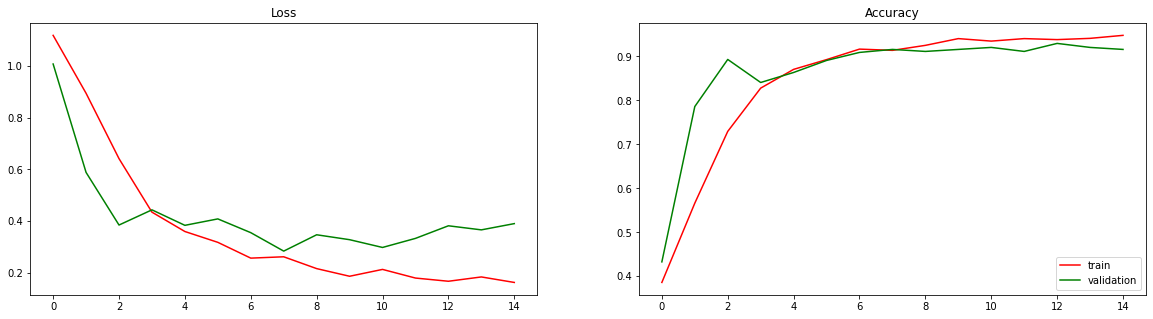

In [ ]:
show_accuracy_and_loss_trands(history_1_adam)

In [ ]:
model_1_adam_acc = show_eval(model_1, val)

28/28 [==============================] - 5s 162ms/step - loss: 0.3977 - accuracy: 0.9021
Accuracy: 90


######ADAGRAD

In [ ]:
model_1.compile(adagrad_optimezer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_1_adagrad = model_1.fit(train, epochs=epochs, validation_data=val)

Epoch 1/15
110/110 [==============================] - 36s 329ms/step - loss: 1.0961 - accuracy: 0.3736 - val_loss: 1.0972 - val_accuracy: 0.3417
Epoch 2/15
110/110 [==============================] - 24s 214ms/step - loss: 1.0951 - accuracy: 0.3667 - val_loss: 1.0955 - val_accuracy: 0.4100
Epoch 3/15
110/110 [==============================] - 24s 218ms/step - loss: 1.0926 - accuracy: 0.3761 - val_loss: 1.0909 - val_accuracy: 0.4032
Epoch 4/15
110/110 [==============================] - 24s 218ms/step - loss: 1.0926 - accuracy: 0.3715 - val_loss: 1.0852 - val_accuracy: 0.4191
Epoch 5/15
110/110 [==============================] - 24s 221ms/step - loss: 1.0873 - accuracy: 0.4004 - val_loss: 1.0808 - val_accuracy: 0.4282
Epoch 6/15
110/110 [==============================] - 24s 216ms/step - loss: 1.0878 - accuracy: 0.3789 - val_loss: 1.0713 - val_accuracy: 0.3713
Epoch 7/15
110/110 [==============================] - 24s 217ms/step - loss: 1.0774 - accuracy: 0.3994 - val_loss: 1.0626 - val_ac

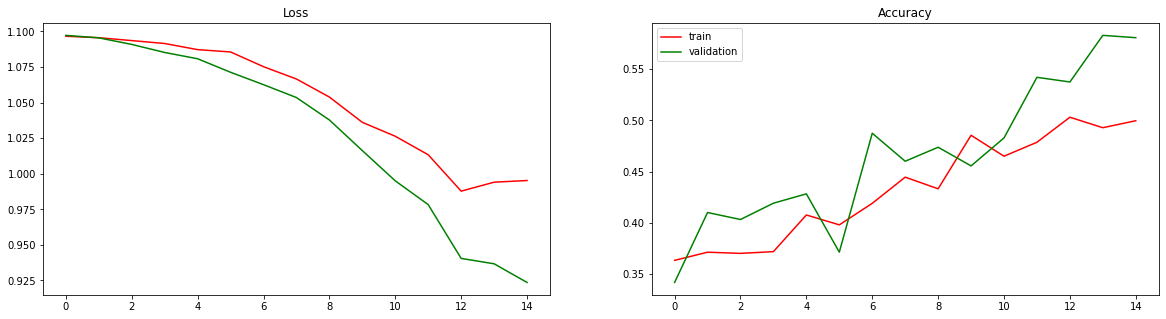

In [ ]:
show_accuracy_and_loss_trands(history_1_adagrad)

In [ ]:
model_1_adagrad_acc = show_eval(model_1, val)

28/28 [==============================] - 5s 165ms/step - loss: 0.9306 - accuracy: 0.5376
Accuracy: 54


####Test data

######ADAM

In [ ]:
model_1.compile(adam_optimezer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_1_adam_2 = model_1.fit(pre_train, epochs=epochs, validation_data=pre_val)

Epoch 1/15
110/110 [==============================] - 23s 207ms/step - loss: 1.3314 - accuracy: 0.3452 - val_loss: 1.0985 - val_accuracy: 0.3349
Epoch 2/15
110/110 [==============================] - 23s 206ms/step - loss: 1.0993 - accuracy: 0.3294 - val_loss: 1.0984 - val_accuracy: 0.3417
Epoch 3/15
110/110 [==============================] - 22s 204ms/step - loss: 1.0972 - accuracy: 0.3630 - val_loss: 1.0984 - val_accuracy: 0.3417
Epoch 4/15
110/110 [==============================] - 23s 207ms/step - loss: 1.0986 - accuracy: 0.3570 - val_loss: 1.0984 - val_accuracy: 0.3417
Epoch 5/15
110/110 [==============================] - 23s 205ms/step - loss: 1.0974 - accuracy: 0.3556 - val_loss: 1.0984 - val_accuracy: 0.3417
Epoch 6/15
110/110 [==============================] - 23s 205ms/step - loss: 1.0986 - accuracy: 0.3336 - val_loss: 1.0984 - val_accuracy: 0.3417
Epoch 7/15
110/110 [==============================] - 22s 204ms/step - loss: 1.0987 - accuracy: 0.3253 - val_loss: 1.0984 - val_ac

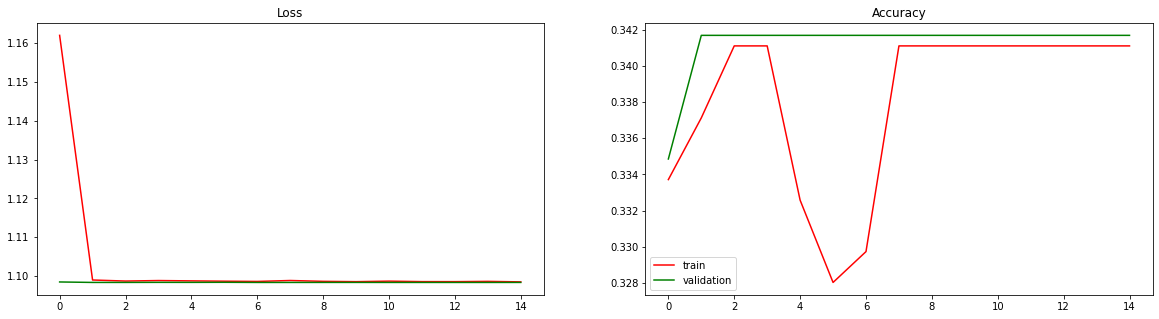

In [ ]:
show_accuracy_and_loss_trands(history_1_adam_2)

In [ ]:
model_1_adam_2_acc = show_eval(model_1)

28/28 [==============================] - 5s 160ms/step - loss: 1.0984 - accuracy: 0.3417
Accuracy: 34


###Model2

Setting the first few layers to not trainable so weights wont be tweaked
After that, allow all other layers to be trained on the RPS images


In [ ]:
pretrained = VGG16(weights='imagenet', include_top=False, pooling='max', input_shape=(pixels,pixels,channels))

for layer in pretrained.layers[:4]:
    layer.trainable=False
for layer in pretrained.layers[4:]:
    layer.trainable=True

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
model_2 = Sequential([
     pretrained, 
     Dense(256), 
     Dense(512), 
     Dense(num_classes, activation='softmax')]
)

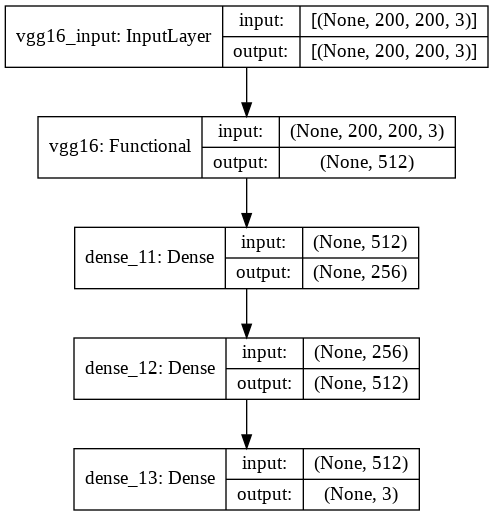

In [ ]:
plot_model(model_2, show_shapes=True, show_layer_names=True)

####Test optimizers

######SGD

In [ ]:
model_2.compile(sgd_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_2_sgd = model_2.fit(train, epochs=epochs, validation_data=val)

Epoch 1/15
110/110 [==============================] - 33s 281ms/step - loss: 0.4279 - accuracy: 0.8590 - val_loss: 0.0760 - val_accuracy: 0.9749
Epoch 2/15
110/110 [==============================] - 29s 263ms/step - loss: 0.0443 - accuracy: 0.9858 - val_loss: 0.0703 - val_accuracy: 0.9772
Epoch 3/15
110/110 [==============================] - 29s 265ms/step - loss: 0.0318 - accuracy: 0.9834 - val_loss: 0.0918 - val_accuracy: 0.9613
Epoch 4/15
110/110 [==============================] - 29s 263ms/step - loss: 0.0154 - accuracy: 0.9932 - val_loss: 0.1368 - val_accuracy: 0.9658
Epoch 5/15
110/110 [==============================] - 29s 264ms/step - loss: 0.0437 - accuracy: 0.9911 - val_loss: 0.0565 - val_accuracy: 0.9772
Epoch 6/15
110/110 [==============================] - 29s 266ms/step - loss: 0.0128 - accuracy: 0.9960 - val_loss: 0.0913 - val_accuracy: 0.9704
Epoch 7/15
110/110 [==============================] - 29s 264ms/step - loss: 0.0047 - accuracy: 0.9997 - val_loss: 0.0412 - val_ac

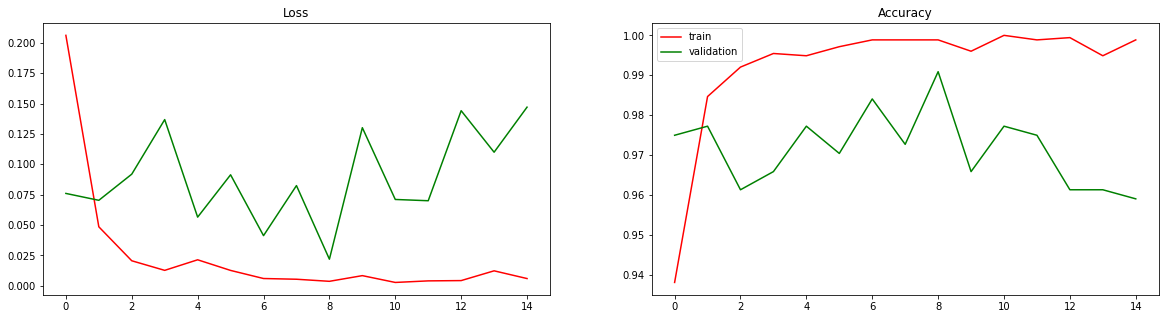

In [ ]:
show_accuracy_and_loss_trands(history_2_sgd)

In [ ]:
model_2_sgd_acc = show_eval(model_2)

28/28 [==============================] - 5s 185ms/step - loss: 0.0911 - accuracy: 0.9704
Accuracy: 97


######ADAM

In [ ]:
model_2.compile(adam_optimezer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_2_adam = model_2.fit(train, epochs=epochs, validation_data=val)

Epoch 1/15
110/110 [==============================] - 30s 268ms/step - loss: 113386.9937 - accuracy: 0.3433 - val_loss: 8.5203 - val_accuracy: 0.3417
Epoch 2/15
110/110 [==============================] - 29s 262ms/step - loss: 3.4332 - accuracy: 0.3336 - val_loss: 1.1623 - val_accuracy: 0.3485
Epoch 3/15
110/110 [==============================] - 29s 262ms/step - loss: 1.1702 - accuracy: 0.3432 - val_loss: 1.1717 - val_accuracy: 0.3280
Epoch 4/15
110/110 [==============================] - 29s 263ms/step - loss: 1.1849 - accuracy: 0.3510 - val_loss: 1.1171 - val_accuracy: 0.3804
Epoch 5/15
110/110 [==============================] - 29s 263ms/step - loss: 1.1315 - accuracy: 0.3435 - val_loss: 1.1469 - val_accuracy: 0.3303
Epoch 6/15
110/110 [==============================] - 29s 262ms/step - loss: 1.1760 - accuracy: 0.3414 - val_loss: 1.1408 - val_accuracy: 0.3326
Epoch 7/15
110/110 [==============================] - 29s 262ms/step - loss: 1.1578 - accuracy: 0.3216 - val_loss: 1.1187 - v

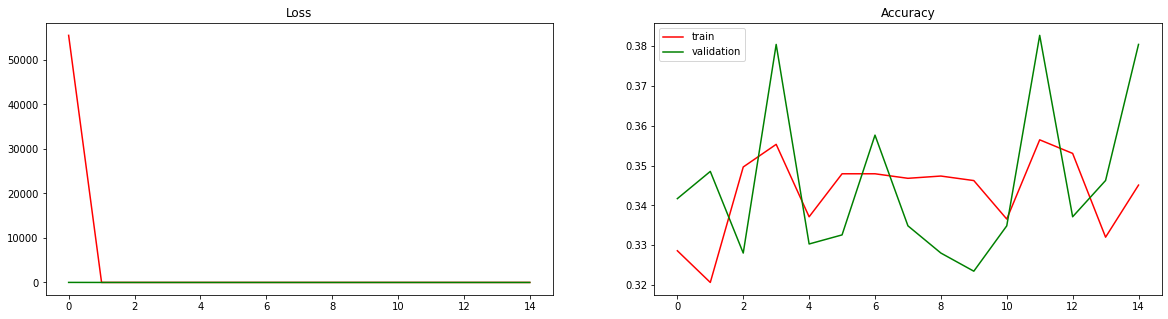

In [ ]:
show_accuracy_and_loss_trands(history_2_adam)

In [ ]:
model_2_adam_acc = show_eval(model_2)

28/28 [==============================] - 5s 186ms/step - loss: 1.0963 - accuracy: 0.3804
Accuracy: 38


######ADAGRAD

In [ ]:
model_2.compile(adagrad_optimezer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_2_adagrad = model_2.fit(train, epochs=epochs, validation_data=val)

Epoch 1/15
110/110 [==============================] - 30s 266ms/step - loss: 1.5945 - accuracy: 0.3420 - val_loss: 1.1470 - val_accuracy: 0.3485
Epoch 2/15
110/110 [==============================] - 29s 262ms/step - loss: 1.1323 - accuracy: 0.3437 - val_loss: 1.1510 - val_accuracy: 0.3349
Epoch 3/15
110/110 [==============================] - 29s 261ms/step - loss: 1.1270 - accuracy: 0.3135 - val_loss: 1.1472 - val_accuracy: 0.3303
Epoch 4/15
110/110 [==============================] - 29s 261ms/step - loss: 1.1070 - accuracy: 0.3559 - val_loss: 1.1865 - val_accuracy: 0.3212
Epoch 5/15
110/110 [==============================] - 29s 263ms/step - loss: 1.1171 - accuracy: 0.3428 - val_loss: 1.1032 - val_accuracy: 0.3690
Epoch 6/15
110/110 [==============================] - 29s 265ms/step - loss: 1.1067 - accuracy: 0.3640 - val_loss: 1.1138 - val_accuracy: 0.3485
Epoch 7/15
110/110 [==============================] - 29s 262ms/step - loss: 1.1023 - accuracy: 0.3713 - val_loss: 1.1054 - val_ac

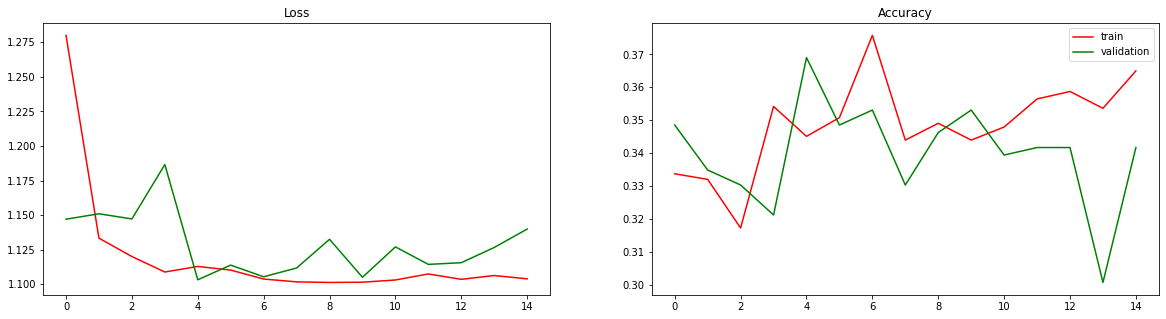

In [ ]:
show_accuracy_and_loss_trands(history_2_adagrad)

In [ ]:
model_2_adagrad_acc = show_eval(model_2)

28/28 [==============================] - 5s 185ms/step - loss: 1.1360 - accuracy: 0.3508
Accuracy: 35


####Test data

######ADAM

In [ ]:
model_2.compile(adam_optimezer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_2_adam_2 = model_2.fit(pre_train, epochs=epochs, validation_data=pre_val)

Epoch 1/15
110/110 [==============================] - 570s 5s/step - loss: 1.1570 - accuracy: 0.3403 - val_loss: 1.1169 - val_accuracy: 0.3667
Epoch 2/15
110/110 [==============================] - 28s 251ms/step - loss: 1.1211 - accuracy: 0.3532 - val_loss: 1.1523 - val_accuracy: 0.3235
Epoch 3/15
110/110 [==============================] - 28s 251ms/step - loss: 1.1264 - accuracy: 0.3278 - val_loss: 1.1560 - val_accuracy: 0.3189
Epoch 4/15
110/110 [==============================] - 28s 254ms/step - loss: 1.1202 - accuracy: 0.3487 - val_loss: 1.1821 - val_accuracy: 0.3052
Epoch 5/15
110/110 [==============================] - 28s 253ms/step - loss: 1.1646 - accuracy: 0.3253 - val_loss: 1.1482 - val_accuracy: 0.3371
Epoch 6/15
110/110 [==============================] - 28s 253ms/step - loss: 1.1163 - accuracy: 0.3509 - val_loss: 1.1302 - val_accuracy: 0.3121
Epoch 7/15
110/110 [==============================] - 28s 255ms/step - loss: 1.1227 - accuracy: 0.3120 - val_loss: 1.1651 - val_accu

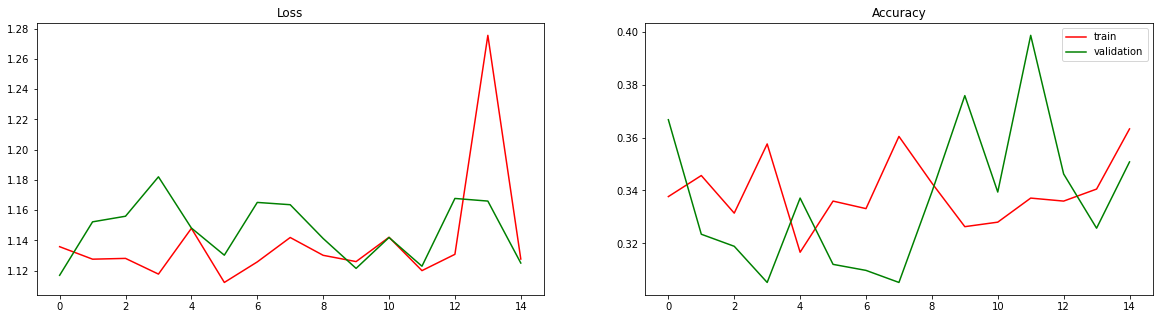

In [ ]:
show_accuracy_and_loss_trands(history_2_adam_2)

In [ ]:
model_2_adam_2_acc = show_eval(model_2)

28/28 [==============================] - 5s 185ms/step - loss: 1.1132 - accuracy: 0.3189
Accuracy: 32


###Model3

In [ ]:
model_3 = Sequential(
    [
      Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(pixels,pixels,channels)),
      MaxPooling2D((2, 2)),
      Conv2D(64, (3, 3), activation='relu'),
      MaxPooling2D((2, 2)),
      Dropout(rate=0.25),
      Conv2D(128, (3, 3), activation='relu'),
      MaxPooling2D((2, 2)),
      Dropout(rate=0.25),
      Conv2D(256, (3, 3), activation='relu'),
      MaxPooling2D((2, 2)),
      Flatten(),
      Dropout(rate=0.5),
      Dense(512, activation='relu'),
      Dense(3, activation='softmax')
    ]
)

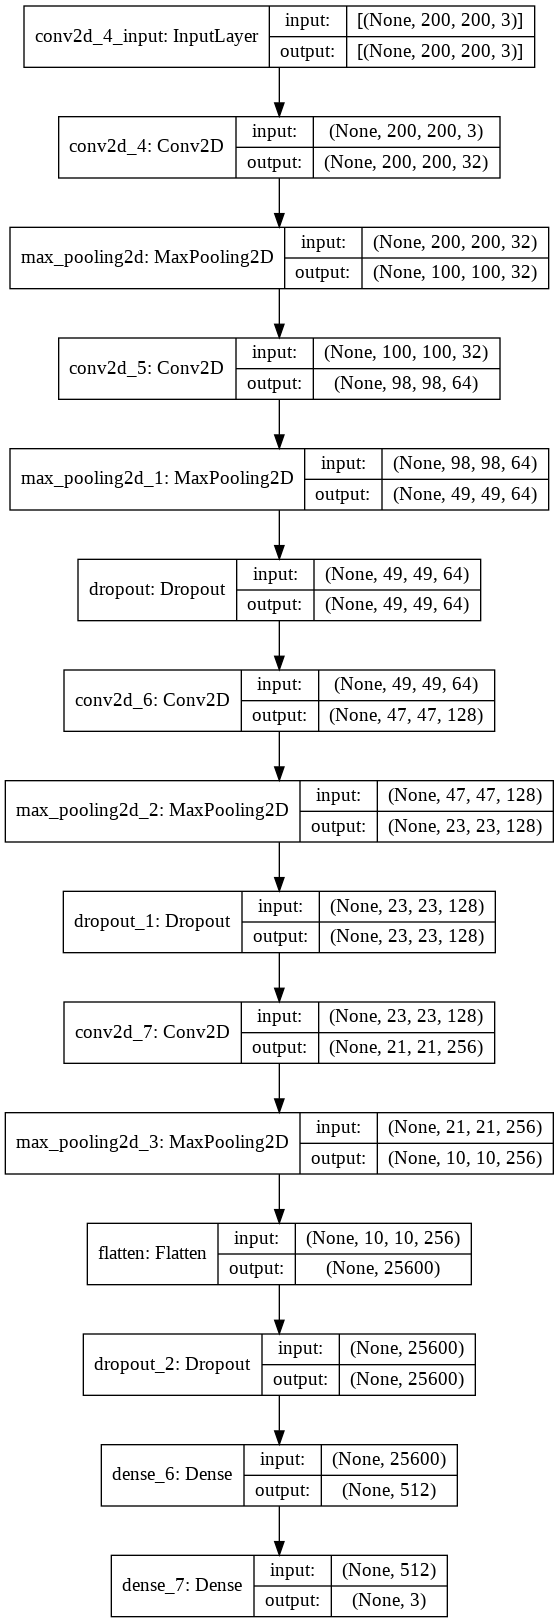

In [ ]:
plot_model(model_3, show_shapes=True, show_layer_names=True)

####Test optimizers

######SGD

In [ ]:
model_3.compile(sgd_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_3_sgd = model_3.fit(train, epochs=epochs, validation_data=val)

Epoch 1/15
110/110 [==============================] - 25s 223ms/step - loss: 1.1068 - accuracy: 0.3323 - val_loss: 1.0984 - val_accuracy: 0.3462
Epoch 2/15
110/110 [==============================] - 24s 217ms/step - loss: 1.1007 - accuracy: 0.3324 - val_loss: 1.0973 - val_accuracy: 0.3554
Epoch 3/15
110/110 [==============================] - 24s 217ms/step - loss: 1.0971 - accuracy: 0.3596 - val_loss: 1.0942 - val_accuracy: 0.3736
Epoch 4/15
110/110 [==============================] - 24s 218ms/step - loss: 1.0943 - accuracy: 0.3572 - val_loss: 1.0924 - val_accuracy: 0.3759
Epoch 5/15
110/110 [==============================] - 24s 217ms/step - loss: 1.0940 - accuracy: 0.3640 - val_loss: 1.0905 - val_accuracy: 0.4237
Epoch 6/15
110/110 [==============================] - 24s 218ms/step - loss: 1.0898 - accuracy: 0.3847 - val_loss: 1.0853 - val_accuracy: 0.4465
Epoch 7/15
110/110 [==============================] - 24s 218ms/step - loss: 1.0845 - accuracy: 0.4170 - val_loss: 1.0842 - val_ac

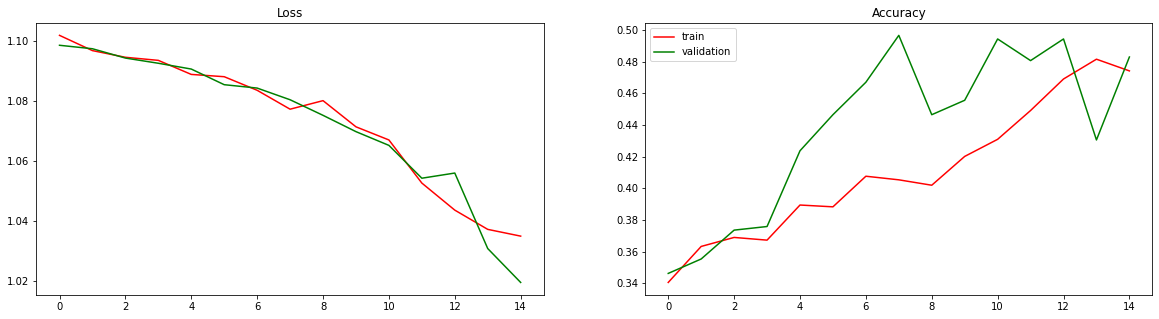

In [ ]:
show_accuracy_and_loss_trands(history_3_sgd)

In [ ]:
model_3_sgd_acc = show_eval(model_3)

28/28 [==============================] - 5s 165ms/step - loss: 1.0238 - accuracy: 0.4624
Accuracy: 46


######ADAM

In [ ]:
model_3.compile(adam_optimezer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_3_adam = model_3.fit(train, epochs=epochs, validation_data=val)

Epoch 1/15
110/110 [==============================] - 25s 220ms/step - loss: 1.6164 - accuracy: 0.3285 - val_loss: 1.0984 - val_accuracy: 0.3417
Epoch 2/15
110/110 [==============================] - 24s 218ms/step - loss: 1.0993 - accuracy: 0.3255 - val_loss: 1.0984 - val_accuracy: 0.3417
Epoch 3/15
110/110 [==============================] - 24s 222ms/step - loss: 1.0983 - accuracy: 0.3637 - val_loss: 1.0984 - val_accuracy: 0.3417
Epoch 4/15
110/110 [==============================] - 24s 221ms/step - loss: 1.0987 - accuracy: 0.3295 - val_loss: 1.0984 - val_accuracy: 0.3417
Epoch 5/15
110/110 [==============================] - 24s 219ms/step - loss: 1.0980 - accuracy: 0.3493 - val_loss: 1.0984 - val_accuracy: 0.3417
Epoch 6/15
110/110 [==============================] - 24s 218ms/step - loss: 1.0980 - accuracy: 0.3465 - val_loss: 1.0984 - val_accuracy: 0.3417
Epoch 7/15
110/110 [==============================] - 24s 219ms/step - loss: 1.0988 - accuracy: 0.3261 - val_loss: 1.0984 - val_ac

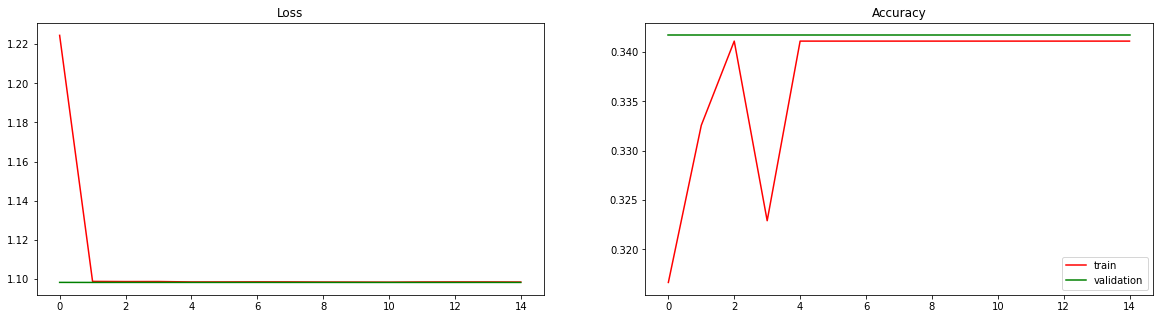

In [ ]:
show_accuracy_and_loss_trands(history_3_adam)

In [ ]:
model_3_adam_acc = show_eval(model_3)

28/28 [==============================] - 5s 164ms/step - loss: 1.0984 - accuracy: 0.3417
Accuracy: 34


######ADAGRAD

In [ ]:
model_3.compile(adagrad_optimezer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_3_adagrad = model_3.fit(train, epochs=epochs, validation_data=val)

Epoch 1/15
110/110 [==============================] - 25s 222ms/step - loss: 1.0983 - accuracy: 0.3469 - val_loss: 1.0984 - val_accuracy: 0.3417
Epoch 2/15
110/110 [==============================] - 24s 219ms/step - loss: 1.0981 - accuracy: 0.3510 - val_loss: 1.0984 - val_accuracy: 0.3417
Epoch 3/15
110/110 [==============================] - 24s 217ms/step - loss: 1.0981 - accuracy: 0.3469 - val_loss: 1.0984 - val_accuracy: 0.3417
Epoch 4/15
110/110 [==============================] - 24s 218ms/step - loss: 1.0980 - accuracy: 0.3488 - val_loss: 1.0984 - val_accuracy: 0.3417
Epoch 5/15
110/110 [==============================] - 24s 218ms/step - loss: 1.0980 - accuracy: 0.3600 - val_loss: 1.0984 - val_accuracy: 0.3417
Epoch 6/15
110/110 [==============================] - 24s 219ms/step - loss: 1.0987 - accuracy: 0.3346 - val_loss: 1.0984 - val_accuracy: 0.3417
Epoch 7/15
110/110 [==============================] - 24s 217ms/step - loss: 1.0988 - accuracy: 0.3330 - val_loss: 1.0984 - val_ac

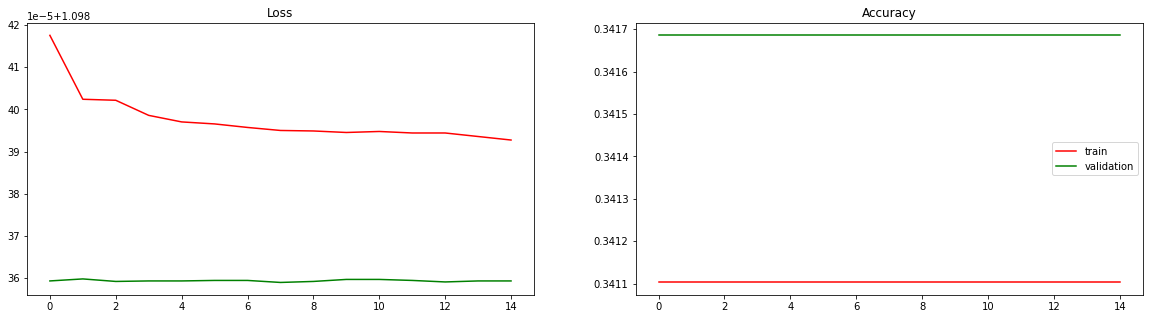

In [ ]:
show_accuracy_and_loss_trands(history_3_adagrad)

In [ ]:
model_3_adagrad_acc = show_eval(model_3)

28/28 [==============================] - 5s 164ms/step - loss: 1.0984 - accuracy: 0.3417
Accuracy: 34


####Test data

######ADAM

In [ ]:
model_3.compile(adam_optimezer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_3_adam_2 = model_3.fit(pre_train, epochs=epochs, validation_data=pre_val)

Epoch 1/15
110/110 [==============================] - 24s 212ms/step - loss: 1.0980 - accuracy: 0.3540 - val_loss: 1.0984 - val_accuracy: 0.3417
Epoch 2/15
110/110 [==============================] - 23s 209ms/step - loss: 1.0992 - accuracy: 0.3181 - val_loss: 1.0984 - val_accuracy: 0.3417
Epoch 3/15
110/110 [==============================] - 23s 210ms/step - loss: 1.0990 - accuracy: 0.3388 - val_loss: 1.0984 - val_accuracy: 0.3417
Epoch 4/15
110/110 [==============================] - 23s 210ms/step - loss: 1.0987 - accuracy: 0.3275 - val_loss: 1.0984 - val_accuracy: 0.3417
Epoch 5/15
110/110 [==============================] - 23s 210ms/step - loss: 1.0987 - accuracy: 0.3260 - val_loss: 1.0984 - val_accuracy: 0.3417
Epoch 6/15
110/110 [==============================] - 23s 213ms/step - loss: 1.0982 - accuracy: 0.3351 - val_loss: 1.0984 - val_accuracy: 0.3417
Epoch 7/15
110/110 [==============================] - 23s 210ms/step - loss: 1.0988 - accuracy: 0.3360 - val_loss: 1.0984 - val_ac

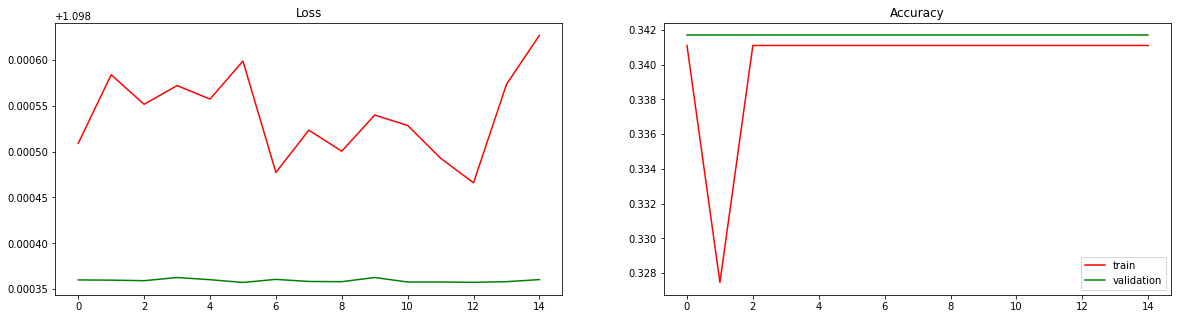

In [ ]:
show_accuracy_and_loss_trands(history_3_adam_2)

In [ ]:
model_3_adam_2_acc = show_eval(model_3)

28/28 [==============================] - 5s 163ms/step - loss: 1.0984 - accuracy: 0.3417
Accuracy: 34


###Model4
Something strange here - train acc - great, but val is really low. 

In [ ]:
pretrained = ResNet50(weights='imagenet', include_top=False, pooling='max', input_shape=(pixels,pixels,channels))

for layer in pretrained.layers[:4]:
    layer.trainable=False
for layer in pretrained.layers[4:]:
    layer.trainable=True

In [ ]:
model_4 = Sequential([
     pretrained, 
     Dense(256), 
     Dense(512), 
     Dense(num_classes, activation='softmax')]
)

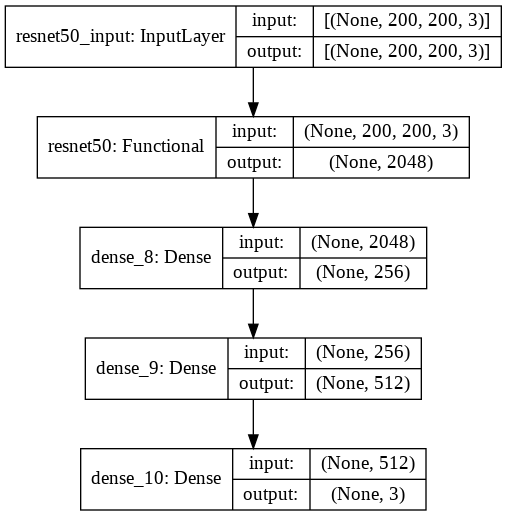

In [ ]:
plot_model(model_4, show_shapes=True, show_layer_names=True)

####Test optimizers

######SGD

In [ ]:
model_4.compile(sgd_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_4_sgd = model_4.fit(train, epochs=epochs, validation_data=val)

Epoch 1/15
110/110 [==============================] - 35s 285ms/step - loss: 5.7980 - accuracy: 0.8141 - val_loss: 3.3285 - val_accuracy: 0.3349
Epoch 2/15
110/110 [==============================] - 30s 272ms/step - loss: 0.0287 - accuracy: 0.9910 - val_loss: 2.8887 - val_accuracy: 0.3326
Epoch 3/15
110/110 [==============================] - 30s 269ms/step - loss: 0.0583 - accuracy: 0.9907 - val_loss: 2.4036 - val_accuracy: 0.3189
Epoch 4/15
110/110 [==============================] - 30s 269ms/step - loss: 0.0513 - accuracy: 0.9913 - val_loss: 1.6116 - val_accuracy: 0.3257
Epoch 5/15
110/110 [==============================] - 30s 268ms/step - loss: 0.0154 - accuracy: 0.9943 - val_loss: 6.6993 - val_accuracy: 0.3349
Epoch 6/15
110/110 [==============================] - 30s 270ms/step - loss: 0.0070 - accuracy: 0.9972 - val_loss: 3.1753 - val_accuracy: 0.3326
Epoch 7/15
110/110 [==============================] - 30s 269ms/step - loss: 0.0196 - accuracy: 0.9977 - val_loss: 5.0805 - val_ac

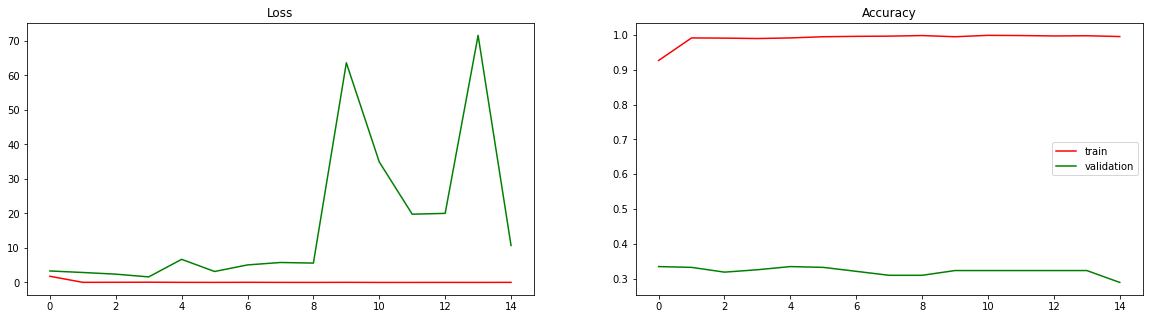

In [ ]:
show_accuracy_and_loss_trands(history_4_sgd)

In [ ]:
model_4_sgd_acc = show_eval(model_4, val)

28/28 [==============================] - 5s 189ms/step - loss: 10.9994 - accuracy: 0.2847
Accuracy: 28


######ADAM

In [ ]:
model_4.compile(adam_optimezer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_4_adam = model_4.fit(train, epochs=epochs, validation_data=val)

Epoch 1/15
110/110 [==============================] - 35s 282ms/step - loss: 41.6235 - accuracy: 0.4325 - val_loss: 445268.6250 - val_accuracy: 0.3349
Epoch 2/15
110/110 [==============================] - 30s 274ms/step - loss: 0.9115 - accuracy: 0.5707 - val_loss: 2135.4133 - val_accuracy: 0.3235
Epoch 3/15
110/110 [==============================] - 30s 271ms/step - loss: 0.7477 - accuracy: 0.6028 - val_loss: 136.6330 - val_accuracy: 0.3235
Epoch 4/15
110/110 [==============================] - 30s 273ms/step - loss: 0.7439 - accuracy: 0.6136 - val_loss: 26.9939 - val_accuracy: 0.3349
Epoch 5/15
110/110 [==============================] - 30s 272ms/step - loss: 0.6599 - accuracy: 0.6262 - val_loss: 3.4567 - val_accuracy: 0.4009
Epoch 6/15
110/110 [==============================] - 30s 271ms/step - loss: 0.6416 - accuracy: 0.6415 - val_loss: 107.0186 - val_accuracy: 0.3417
Epoch 7/15
110/110 [==============================] - 30s 271ms/step - loss: 0.6298 - accuracy: 0.6022 - val_loss: 1

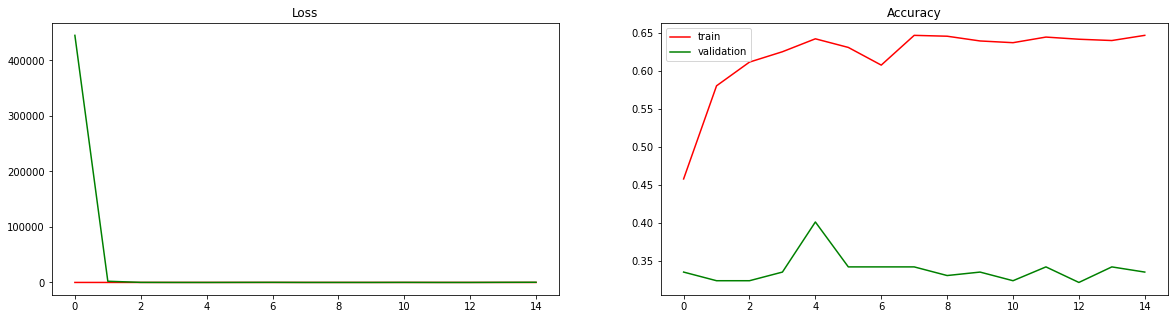

In [ ]:
show_accuracy_and_loss_trands(history_4_adam)

In [ ]:
model_4_adam_acc = show_eval(model_4, val)

28/28 [==============================] - 5s 185ms/step - loss: 327.3364 - accuracy: 0.3349
Accuracy: 33


######ADAGRAD

In [ ]:
model_4.compile(adagrad_optimezer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_4_adagrad = model_4.fit(train, epochs=epochs, validation_data=val)

Epoch 1/15
110/110 [==============================] - 35s 284ms/step - loss: 0.0227 - accuracy: 0.9962 - val_loss: 3.6659 - val_accuracy: 0.3371
Epoch 2/15
110/110 [==============================] - 31s 284ms/step - loss: 0.0816 - accuracy: 0.9913 - val_loss: 4.7504 - val_accuracy: 0.3394
Epoch 3/15
110/110 [==============================] - 31s 280ms/step - loss: 0.0303 - accuracy: 0.9940 - val_loss: 3.2692 - val_accuracy: 0.3781
Epoch 4/15
110/110 [==============================] - 31s 281ms/step - loss: 0.0133 - accuracy: 0.9961 - val_loss: 3.9816 - val_accuracy: 0.3690
Epoch 5/15
110/110 [==============================] - 31s 278ms/step - loss: 0.0201 - accuracy: 0.9954 - val_loss: 3.4967 - val_accuracy: 0.5080
Epoch 6/15
110/110 [==============================] - 31s 277ms/step - loss: 0.0120 - accuracy: 0.9956 - val_loss: 3.1150 - val_accuracy: 0.5262
Epoch 7/15
110/110 [==============================] - 31s 282ms/step - loss: 0.0145 - accuracy: 0.9971 - val_loss: 43.2799 - val_a

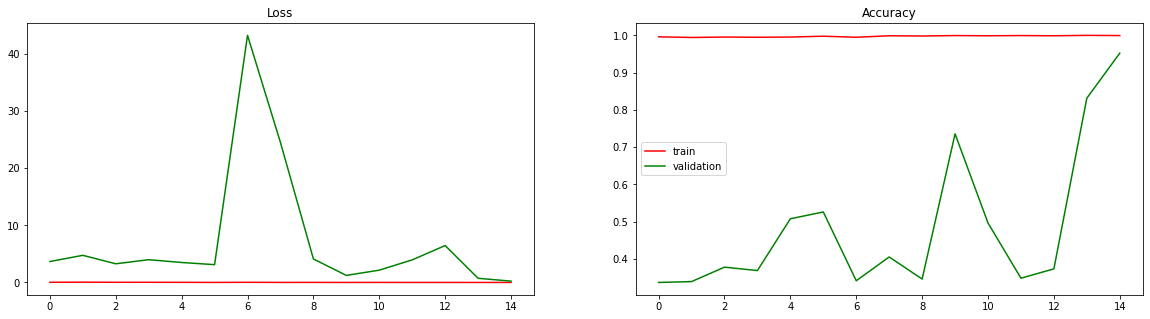

In [ ]:
show_accuracy_and_loss_trands(history_4_adagrad)

In [ ]:
model_4_adagrad_acc = show_eval(model_4, val)

28/28 [==============================] - 5s 181ms/step - loss: 0.1257 - accuracy: 0.9658
Accuracy: 97


####Test data

######ADAM

In [ ]:
model_4.compile(adam_optimezer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_4_adam_2 = model_4.fit(pre_train, epochs=epochs, validation_data=pre_val)

Epoch 1/15
110/110 [==============================] - 400s 4s/step - loss: 1.3174 - accuracy: 0.4293 - val_loss: 632.1759 - val_accuracy: 0.3235
Epoch 2/15
110/110 [==============================] - 29s 259ms/step - loss: 0.6116 - accuracy: 0.6961 - val_loss: 937.1998 - val_accuracy: 0.3235
Epoch 3/15
110/110 [==============================] - 29s 260ms/step - loss: 0.3871 - accuracy: 0.8644 - val_loss: 3551.5295 - val_accuracy: 0.3235
Epoch 4/15
110/110 [==============================] - 29s 260ms/step - loss: 0.1797 - accuracy: 0.9460 - val_loss: 301.7845 - val_accuracy: 0.3235
Epoch 5/15
110/110 [==============================] - 29s 260ms/step - loss: 0.1153 - accuracy: 0.9690 - val_loss: 3449.2603 - val_accuracy: 0.3235
Epoch 6/15
110/110 [==============================] - 29s 259ms/step - loss: 0.1039 - accuracy: 0.9677 - val_loss: 4759.2642 - val_accuracy: 0.3235
Epoch 7/15
110/110 [==============================] - 29s 259ms/step - loss: 0.1317 - accuracy: 0.9676 - val_loss: 12

In [ ]:
show_accuracy_and_loss_trands(history_4_adam_2)

In [ ]:
model_4_adam_2_acc = show_eval(model_4, pre_val)

###Model5

In [ ]:
pretrained = Xception(weights='imagenet', include_top=False, pooling='max', input_shape=(pixels,pixels,channels))

83689472/83683744 [==============================] - 0s 0us/step


In [ ]:
model_5 = Sequential([
     pretrained, 
     Dense(256), 
     Dense(512), 
     Dense(num_classes, activation='softmax')]
)

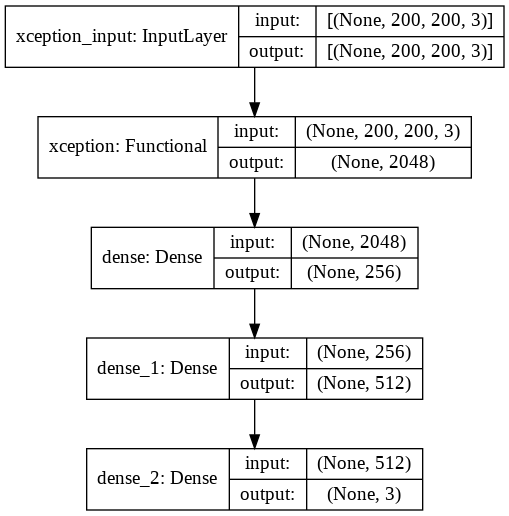

In [ ]:
plot_model(model_5, show_shapes=True, show_layer_names=True)

####Test optimizers

######SGD

In [ ]:
model_5.compile(sgd_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_5_sgd = model_5.fit(train, epochs=epochs, validation_data=val)

Epoch 1/15
110/110 [==============================] - 41s 321ms/step - loss: 1.0202 - accuracy: 0.6122 - val_loss: 0.3823 - val_accuracy: 0.8588
Epoch 2/15
110/110 [==============================] - 33s 301ms/step - loss: 0.2321 - accuracy: 0.9188 - val_loss: 0.1874 - val_accuracy: 0.9317
Epoch 3/15
110/110 [==============================] - 34s 303ms/step - loss: 0.1508 - accuracy: 0.9455 - val_loss: 0.1147 - val_accuracy: 0.9522
Epoch 4/15
110/110 [==============================] - 34s 304ms/step - loss: 0.1018 - accuracy: 0.9732 - val_loss: 0.0940 - val_accuracy: 0.9636
Epoch 5/15
110/110 [==============================] - 34s 304ms/step - loss: 0.0846 - accuracy: 0.9732 - val_loss: 0.0848 - val_accuracy: 0.9749
Epoch 6/15
110/110 [==============================] - 34s 307ms/step - loss: 0.0909 - accuracy: 0.9635 - val_loss: 0.0838 - val_accuracy: 0.9658
Epoch 7/15
110/110 [==============================] - 34s 307ms/step - loss: 0.0515 - accuracy: 0.9787 - val_loss: 0.1335 - val_ac

In [ ]:
show_accuracy_and_loss_trands(history_5_sgd)

In [ ]:
model_5_sgd_acc = show_eval(model_5, val)

######ADAM

In [ ]:
model_5.compile(adam_optimezer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_5_adam = model_5.fit(train, epochs=epochs, validation_data=val)

Epoch 1/15
110/110 [==============================] - 39s 319ms/step - loss: 0.9790 - accuracy: 0.9108 - val_loss: 0.2672 - val_accuracy: 0.9453
Epoch 2/15
110/110 [==============================] - 34s 312ms/step - loss: 0.1179 - accuracy: 0.9740 - val_loss: 0.3505 - val_accuracy: 0.9681
Epoch 3/15
110/110 [==============================] - 34s 311ms/step - loss: 0.0749 - accuracy: 0.9816 - val_loss: 0.3105 - val_accuracy: 0.9317
Epoch 4/15
110/110 [==============================] - 34s 311ms/step - loss: 0.0508 - accuracy: 0.9893 - val_loss: 0.0544 - val_accuracy: 0.9863
Epoch 5/15
110/110 [==============================] - 34s 312ms/step - loss: 0.0329 - accuracy: 0.9885 - val_loss: 0.2372 - val_accuracy: 0.9613
Epoch 6/15
110/110 [==============================] - 35s 313ms/step - loss: 0.0221 - accuracy: 0.9908 - val_loss: 22.7350 - val_accuracy: 0.6378
Epoch 7/15
110/110 [==============================] - 34s 312ms/step - loss: 0.4204 - accuracy: 0.9419 - val_loss: 14454.9980 - v

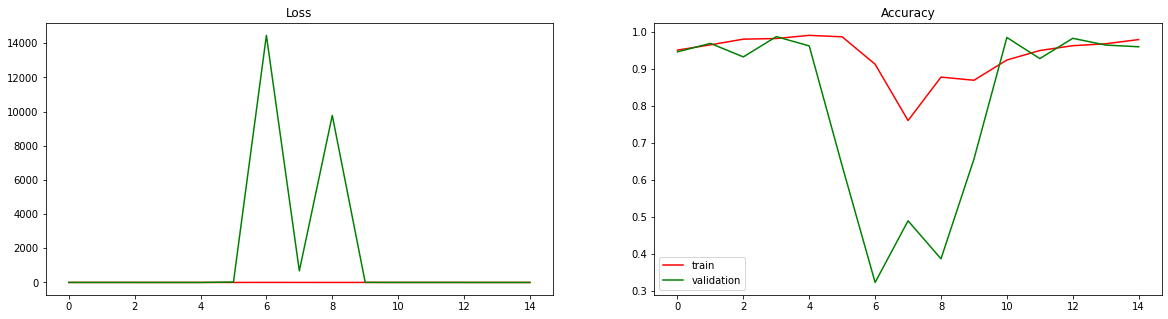

In [ ]:
show_accuracy_and_loss_trands(history_5_adam)

In [ ]:
model_5_adam_acc = show_eval(model_5, val)

28/28 [==============================] - 5s 179ms/step - loss: 0.1452 - accuracy: 0.9590
Accuracy: 96


######ADAGRAD

In [ ]:
model_5.compile(adagrad_optimezer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_5_adagrad = model_5.fit(train, epochs=epochs, validation_data=val)

Epoch 1/15
110/110 [==============================] - 38s 317ms/step - loss: 0.0469 - accuracy: 0.9867 - val_loss: 0.0743 - val_accuracy: 0.9749
Epoch 2/15
110/110 [==============================] - 34s 308ms/step - loss: 0.0447 - accuracy: 0.9876 - val_loss: 0.0922 - val_accuracy: 0.9681
Epoch 3/15
110/110 [==============================] - 34s 310ms/step - loss: 0.3003 - accuracy: 0.9925 - val_loss: 0.0768 - val_accuracy: 0.9841
Epoch 4/15
110/110 [==============================] - 35s 315ms/step - loss: 0.0543 - accuracy: 0.9875 - val_loss: 0.0644 - val_accuracy: 0.9727
Epoch 5/15
110/110 [==============================] - 34s 311ms/step - loss: 0.0598 - accuracy: 0.9819 - val_loss: 0.0684 - val_accuracy: 0.9795
Epoch 6/15
110/110 [==============================] - 35s 313ms/step - loss: 0.0366 - accuracy: 0.9915 - val_loss: 0.0437 - val_accuracy: 0.9841
Epoch 7/15
110/110 [==============================] - 35s 313ms/step - loss: 0.4321 - accuracy: 0.9884 - val_loss: 0.0437 - val_ac

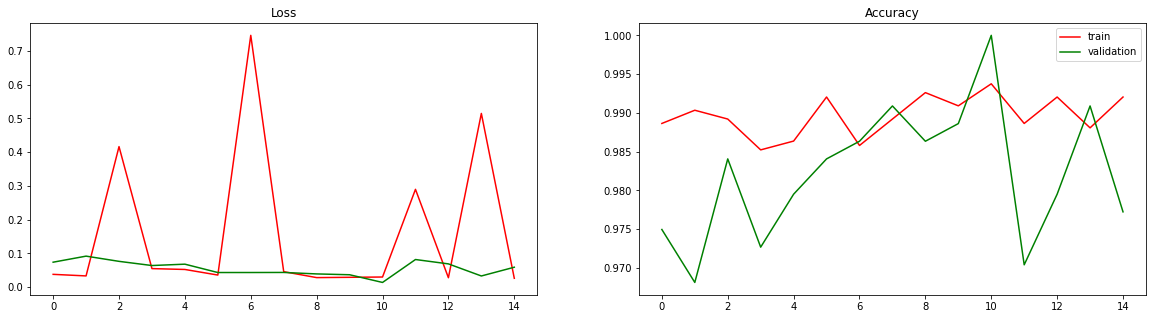

In [ ]:
show_accuracy_and_loss_trands(history_5_adagrad)

In [ ]:
model_5_adagrad_acc = show_eval(model_5, val)

28/28 [==============================] - 5s 182ms/step - loss: 0.0532 - accuracy: 0.9818
Accuracy: 98


####Test data

######ADAM

In [ ]:
model_5.compile(adam_optimezer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_5_adam_2 = model_5.fit(pre_train, epochs=epochs, validation_data=pre_val)

Epoch 1/15
110/110 [==============================] - 38s 318ms/step - loss: 6.7650 - accuracy: 0.3473 - val_loss: 1.0664 - val_accuracy: 0.4419
Epoch 2/15
110/110 [==============================] - 34s 308ms/step - loss: 0.9280 - accuracy: 0.5181 - val_loss: 0.9170 - val_accuracy: 0.5103
Epoch 3/15
110/110 [==============================] - 34s 307ms/step - loss: 0.6894 - accuracy: 0.6194 - val_loss: 1.0908 - val_accuracy: 0.5308
Epoch 4/15
110/110 [==============================] - 34s 310ms/step - loss: 0.5499 - accuracy: 0.6513 - val_loss: 1.0967 - val_accuracy: 0.4692
Epoch 5/15
110/110 [==============================] - 34s 309ms/step - loss: 0.5711 - accuracy: 0.6638 - val_loss: 0.7766 - val_accuracy: 0.5923
Epoch 6/15
110/110 [==============================] - 34s 307ms/step - loss: 0.5756 - accuracy: 0.6410 - val_loss: 0.9747 - val_accuracy: 0.5148
Epoch 7/15
110/110 [==============================] - 34s 308ms/step - loss: 0.5368 - accuracy: 0.6457 - val_loss: 1.3517 - val_ac

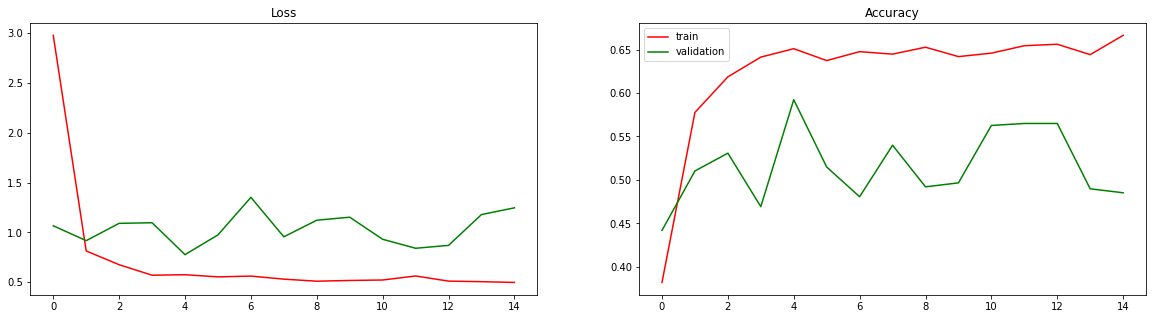

In [ ]:
show_accuracy_and_loss_trands(history_5_adam_2)

In [ ]:
model_5_adam_2_acc = show_eval(model_5, pre_val)

28/28 [==============================] - 5s 174ms/step - loss: 1.1764 - accuracy: 0.4966
Accuracy: 50


## Comparison

Finally


In [80]:
result_df = pd.DataFrame(
    data=[
          [model_1_sgd_acc, model_1_adam_acc, model_1_adam_2_acc, model_1_adagrad_acc], 
          [model_2_sgd_acc, model_2_adam_acc, model_2_adam_2_acc, model_2_adagrad_acc], 
          [model_3_sgd_acc, model_3_adam_acc, model_3_adam_2_acc, model_3_adagrad_acc], 
          [model_4_sgd_acc, model_4_adam_acc, model_4_adam_2_acc, model_4_adagrad_acc], 
          [model_5_sgd_acc, model_5_adam_acc, model_5_adam_2_acc, model_5_adagrad_acc]
          ],
          columns=['SGD','ADAM','ADAM 2ND DS', 'ADAGRAD'],
          index=[  'Complex 1', 'VGG16', 'Complex 2 ', 'ResNet50', 'Xception']
          )
result_df

,SGD,ADAM,ADAM_2ND,ADAGRAD
Complex 1,0.5080,0.9021,0.5417,0.5376
VGG16,0.9704,0.3804,0.3189,0.3508
Complex 2,0.3824,0.3417,0.3417,0.3417
ResNet50,0.2847,0.3349,0.3235,0.9658
Xception,0.9795,0.9590,0.4966,0.4966
